In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats

In [2]:
class LinearReg():
    def __init__(self, data_input):
        self.data = data_input
        self.dict_stats = {}
        
        self.add_stats()
        self.X = self.data.x
        self.y = self.data.y
        
        self.model = sm.OLS(endog=self.y, exog=self.data[['x']].assign(intercept=1)).fit(transform=False)
        self.model_origin = sm.OLS(endog=self.y, exog=self.data[['x']].assign(intercept=0)).fit()
        
        self.df_resumo = pd.DataFrame(columns=['Beta 1', 'se beta 1', 't_beta 1', 'beta 0', 'se beta 0', 't_beta 0', 'r2'])
        self.df_resumo.loc['modelo simples'] = (self.model.params.x, (self.model.params.x/self.model.tvalues.x), self.model.tvalues.x,self.model.params.intercept, (self.model.params.intercept/self.model.tvalues.intercept), self.model.tvalues.intercept,self.model.rsquared)
        self.df_resumo.loc['modelo origem'] = (self.model_origin.params.x, (self.model_origin.params.x/self.model_origin.tvalues.x), self.model_origin.tvalues.x,self.model_origin.params.intercept, (self.model_origin.params.intercept/self.model_origin.tvalues.intercept), self.model_origin.tvalues.intercept,self.model_origin.rsquared)

    def add_stats(self):
        self.data['xy'] = self.data.x * self.data.y
        self.data['x2'] = self.data.x * self.data.x
        self.data['y2'] = self.data.y * self.data.y
        
        for column in self.data.columns:
            self.dict_stats[column] = self.data[column].sum()
    
    def simple_model(self):
        modelo_simples = smf.ols("y ~ X", data={"y": self.y, "X": self.X}).fit()
        
        print(sm.stats.anova_lm(modelo_simples, typ=1))
        display(self.model.summary())
             
    def origin_model(self):
        modelo_intercept = smf.ols("y ~ X -1", data={"y": self.y, "X": self.X}).fit()
        
        print(sm.stats.anova_lm(modelo_intercept, typ=1))
        display(self.model_origin.summary())
        
    def stats_simple_model(self, alpha = 0.05, print_result = False):
        sxy = self.dict_stats['xy']  - (self.dict_stats['x']*self.dict_stats['y'])/len(self.data)
        sxx = self.dict_stats['x2'] - (self.dict_stats['x']**2)/len(self.data)
        # print(f'SXY\t{sxy:.4f}\nSXX\t{sxx:.4f}\n')
        
        x_barra = self.dict_stats['x']/len(self.data)
        y_barra = self.dict_stats['y']/len(self.data)
        
        b1_hat = sxy/sxx
        b0_hat = y_barra - b1_hat*x_barra
        
        SST = self.dict_stats['y2'] - (self.dict_stats['y']**2)/len(self.data)
        SSR = b1_hat * sxy
        SSE = (self.dict_stats['y2'] - ((self.dict_stats['y'])**2)/len(self.data)) - (sxy**2 / sxx)
        r2 = SSR / SST
        
        dof = len(self.data) - 2
        MSE = SSE / dof
        s_b1 = (MSE/sxx)**.5
        s_b0 = (MSE*((1/len(self.data)) + (x_barra**2)/sxx))**.5
        s_err = s_err = MSE**.5

        t_b0 = b0_hat/s_b0
        t_b1 = b1_hat/s_b1
        p_b0 = (1 - stats.t.cdf(abs(t_b0), dof)) * 2
        p_b1 = (1 - stats.t.cdf(abs(t_b1), dof)) * 2
        
        t_ic = stats.t.ppf((1 - 0.5*alpha), df = dof)
        IC_b1 = (b1_hat - t_ic*s_b1, b1_hat + t_ic*s_b1)
        IC_b0 = (b0_hat - t_ic*s_b0, b0_hat + t_ic*s_b0)

        if (print_result):
            print(f'Beta1\t{b1_hat:.4f}\nSe[B1]\t{s_b1:.4f}\nT*[B1]\t{t_b1:.4f}\nP_[B1]\t{p_b1:.4f}\nIC_B1\t[{IC_b1[0]:.4f}, {IC_b1[1]:.4f}]\n')
            print(f'Beta0\t{b0_hat:.4f}\nSe[B0]\t{s_b0:.4f}\nT*[B0]\t{t_b0:.4f}\nP_[B0]\t{p_b0:.4f}\nIC_B0\t[{IC_b0[0]:.4f}, {IC_b0[1]:.4f}]\n')
            
            print(f'SSE\t\t{SSE:.4f}\nSSR\t\t{SSR:.4f}\nSST\t\t{SST:.4f}\nR2\t\t{r2:.4f}\ns_err\t{s_err:.4f}')
        
        return IC_b1, IC_b0
        
    def ic_compute(self, x_h, n_pred = 1, alpha = 0.05, estimation = True):
        sxy = self.dict_stats['xy']  - (self.dict_stats['x']*self.dict_stats['y'])/len(self.data)
        sxx = self.dict_stats['x2'] - (self.dict_stats['x']**2)/len(self.data)
        
        x_barra = self.dict_stats['x']/len(self.data)
        y_barra = self.dict_stats['y']/len(self.data)
        
        b1_hat = sxy/sxx
        b0_hat = y_barra - b1_hat*x_barra
        
        SST = self.dict_stats['y2'] - (self.dict_stats['y']**2)/len(self.data)
        SSR = b1_hat * sxy
        SSE = (self.dict_stats['y2'] - ((self.dict_stats['y'])**2)/len(self.data)) - (sxy**2 / sxx)
        
        dof = len(self.data) - 2
        MSE = SSE / dof

        s_mean = (MSE*((1/len(self.data)) + (((x_h - x_barra)**2) / sxx)))**.5
        s_pred = (MSE*(1/n_pred + (1/len(self.data)) + (((x_h - x_barra)**2) / sxx)))**.5
     
        t_ic = stats.t.ppf((1 - 0.5*alpha), dof)
        y_hat = b0_hat + x_h*b1_hat
        
        ic_mean = (y_hat - t_ic*s_mean, y_hat + t_ic*s_mean)
        ic_pred = (y_hat - t_ic*s_pred, y_hat + t_ic*s_pred)
        
        if(estimation) : print(f'IC resp. media\t[{ic_mean[0]:.4f}, {ic_mean[1]:.4f}]')
        else: print(f'IC predicao\t\t[{ic_pred[0]:.4f}, {ic_pred[1]:.4f}]')
        
        
    def stats_origin_model(self, alpha=0.05, print_result = False):       
        b1_hat = self.dict_stats['xy'] / self.dict_stats['x2']
        
        SST = self.dict_stats['y2']
        SSR = (b1_hat**2)*self.dict_stats['x2']
        SSE = self.dict_stats['y2'] - (b1_hat**2)*self.dict_stats['x2']
        r2 = SSR / SST
        
        dof = len(self.data) - 1
        
        MSE = SSE / dof
        s_b1 = (MSE/self.dict_stats['x2'])**.5
        s_err = MSE**.5

        t_b1 = b1_hat/s_b1
        p_b1 = (1 - stats.t.cdf(abs(t_b1), dof)) * 2
        
        t_ic = stats.t.ppf((1 - 0.5*alpha), df = dof)
        IC_b1 = (b1_hat - t_ic*s_b1, b1_hat + t_ic*s_b1)
        
        if (print_result):
            print(f'Beta1\t{b1_hat:.4f}\nSe[B1]\t{s_b1:.4f}\nT*[B1]\t{t_b1:.4f}\nP_[B1]\t{p_b1:.4f}\nIC_B1\t[{IC_b1[0]:.4f}, {IC_b1[1]:.4f}]\n')
            print(f'SSE\t\t{SSE:.4f}\nSSR\t\t{SSR:.4f}\nSST\t\t{SST:.4f}\nR2\t\t{r2:.4f}\ns_err\t{s_err:.4f}')
        
        return IC_b1
        
        
def plot_expanaly(data):
    fig, axs = plt.subplots(2, 2, figsize=(20,7))
    fig.suptitle("Distribuição das variáveis")
    
    ax = axs[0][0]
    sns.histplot(data=data, x='Height', bins = 75, kde = True, label='Height', ax = ax)
    
    ax.set_title(f"Distribuição - Height")
    ax.set_xlabel("Height")
    ax.set_ylabel("Total")
    ax.set_ylim(0, 720)
    
    ax = axs[0][1]
    sns.histplot(data=data, x='Rings', bins = 30, kde = True, label = "Rings", ax = ax)
    
    ax.set_title(f"Distribuição - Rings")
    ax.set_xlabel("# Rings")
    ax.set_ylabel("Total")
    ax.set_ylim(0, 720)
    
    corr_pearson = data.corr(method='pearson')
    corr_spearman = data.corr(method='spearman')
    
    ax = axs[1][0]
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Matriz de Correlação de Pearson")
    
    ax = axs[1][1]
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Matriz de Correlação de Spearman")
    
    plt.tight_layout()
    
def dict_out(data):
    dict_outliers = {}
    for variable in data.columns:
        z_scores = np.abs(stats.zscore(data[variable]))
        z_threshold = 3
    
        outlier_index = np.where(z_scores > z_threshold)
        dict_outliers[variable] = outlier_index
        
    print(f"Número de outliers :\nHeight\t{len(dict_outliers['Height'][0])}\nRings\t{len(dict_outliers['Rings'][0])}\n")
    
    return dict_outliers

def describe_data(data):
    for category in data.columns:
        print(f"A categoria {category} tem média {data[category].mean():.4f} e desvio padrão {data[category].std():.4f}, com valores no intervalo [{data[category].min():.4f}, {data[category].max():.4f}].")
        
        if(category == "Height"): print('Essa variável é medida em mm.\n')
        else: print('Essa variável é um inteiro.')

# Exercício 7

In [3]:
X = [0.5, 1.5, 3.2, 4.2, 5.1, 6.5]
Y = [1.3, 3.4, 6.7, 8, 10, 13.2]

df = pd.DataFrame({'x' : X, 'y' : Y})
LR = LinearReg(df)

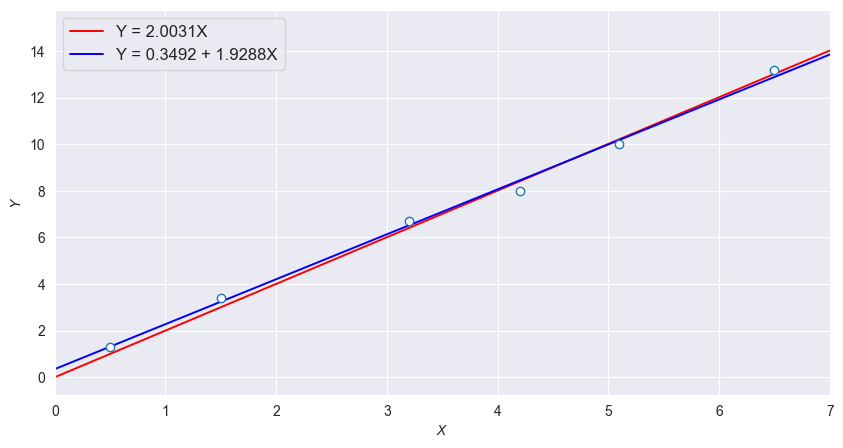

In [4]:
B_hat = LR.model_origin.params.x
bhat_0, bhat_1 = LR.model.params.intercept, LR.model.params.x

x_plot = np.linspace(0, df['x'].iloc[-1]+1, 100)
y_origem = x_plot*B_hat
y_hat = bhat_0 + x_plot*bhat_1

fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 

ax.plot(x_plot,y_origem,'-',color='red',linewidth=1.4,label=f'Y = {B_hat:.4f}X')
ax.plot(x_plot,y_hat,'-',color='blue',linewidth=1.4,label=f'Y = {bhat_0:.4f} + {bhat_1:.4f}X')
ax.plot(df['x'],df['y'], 'o',markerfacecolor='white')

ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
ax.legend(loc='upper left',fontsize=12)

ax.set_xlim([0,df['x'].iloc[-1]+0.5]);

In [5]:
_, ic_b0 = LR.stats_simple_model(alpha = 0.10, print_result = False)
t_b0 = LR.df_resumo.loc['modelo simples']['t_beta 0']
p_b0 = (1 - stats.t.cdf(t_b0, df=len(df) - 2)) * 2
t_critico = stats.t.ppf(0.95, df=len(df) - 2)

print(f"p-valor = {p_b0 :.4f}\t T_calculado = {t_b0:.4f}\tT_crítico = {t_critico:.4f}")
print(f"Intervalo de confiança 90%\t[{ic_b0[0]:.4f}, {ic_b0[1]:.4f}]")
print("De acordo com o resultado acima, não rejeita-se H0, e portanto podemos considerar Beta_0 = 0")

p-valor = 0.2401	 T_calculado = 1.3785	T_crítico = 2.1318
Intervalo de confiança 90%	[-0.1909, 0.8893]
De acordo com o resultado acima, não rejeita-se H0, e portanto podemos considerar Beta_0 = 0


## 8.a)
A predição da idade do molusco abalone, exemplificado nas figuras abaixo, pode ser realizada, de forma empírica, cortando sua concha através do cone, aplicando um corante e contando o número de anéis através de um microscópio. Tal procedimento, além de consumir tempo, está sujeito a erros experimentais e depende de recursos humanos e laboratoriais.

![alt text](Haliotis_asinina.jpg "") ![alt text](Haliotis_parva.jpg "")

Desta maneira, caso seja possível abordar o problema de predizer a idade do animal a partir de outras características físicas instrínsecas, sendo essas de fácil obtenção e medição experimental, como por exemplo o diâmetro da concha, o sexo do animal, peso, etc, essa abordagem seria preferível - caso apresente suficiente acurácia.

Portanto, no presente trabalho busca-se predizer da idade dos moluscos a partir da correlação de medidas físicas, no caso será utilizada a altura da concha para predizer o número médio de anéis, a partir da modelagem dessa relação como uma Regressão Linear. Sabe-se de antemão que o número médio de anéis guarda semelhança linear com a idade do animal, sendo uma relação de que a idade é igual ao número médio de anéis mais 1.5 unidades (de acordo com o exposto na base de dados original).

# 8.b) Análise exploratória dos dados

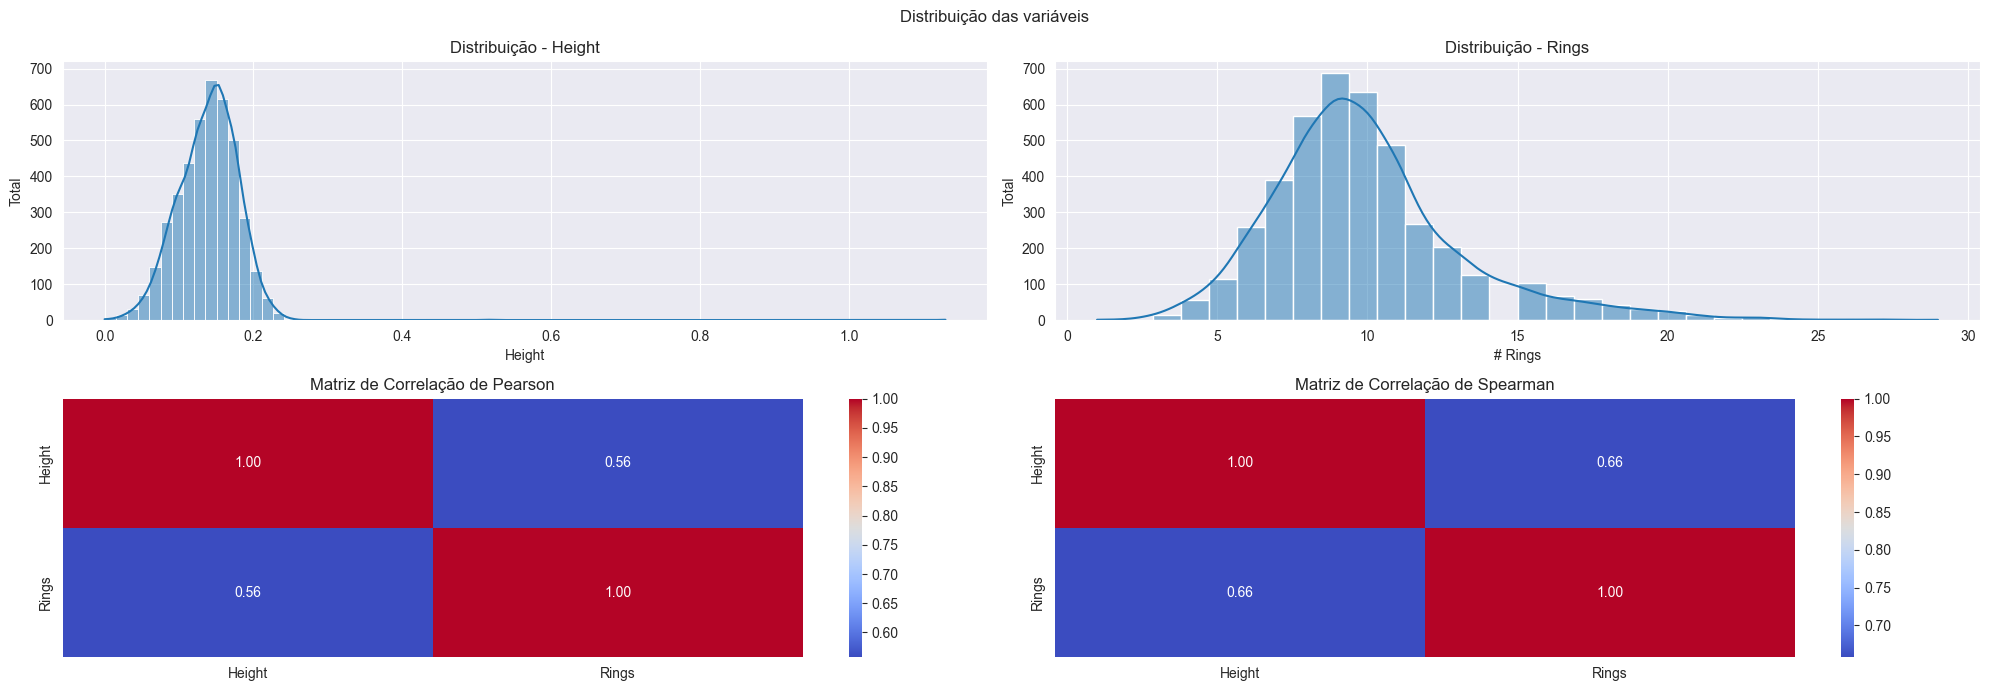

In [6]:
df_molusco = pd.read_csv('molusco.csv')
plot_expanaly(df_molusco)

In [7]:
dict_outliers = dict_out(df_molusco)
describe_data(df_molusco)

Número de outliers :
Height	5
Rings	62

A categoria Height tem média 0.1395 e desvio padrão 0.0418, com valores no intervalo [0.0000, 1.1300].
Essa variável é medida em mm.

A categoria Rings tem média 9.9337 e desvio padrão 3.2242, com valores no intervalo [1.0000, 29.0000].
Essa variável é um inteiro.


É possível observar as distribuições das varíáveis nos histogramas acima, sendo evidente que os dados estão relativamente bem distribuídos nos ranges. Calcula-se as correlações entre Height e número de anéis, obtendo-se os valores de 0.56 e 0.66 para as correlações de Pearson e Spearman, respectivamente.

Também calcula-se o número de outliers, considerando para isso os valores com mais de 3 desvios padrões como valores extremos, bem como expõe-se a média, desvio padrão, unidade de medida e range dos dados.

A seguir são plotados dois gráficos: o primeiro representa as distribuições, no qual é possível observar no plot superior direito a concentração dos dados em torno das médias das variáveis, evidênciando que os dados tem mais dispersão em relação à variável número de anéis e são mais concentrados se tratando da variável Height. No mesmo gráfico plota-se a dispersão dos dados e uma linha de regressão ajustada.

No segundo gráfico são plotadas as distribuições da variável Height para cada valor de número de anéis, sendo evidende que entre 2 e 8 anéis ocorre um crescimento linear nos respectivos valores da variável Height e para 9 ou mais anéis a mediana da variável Height assume valores entre 0.15 e 0.20, comportamento esse que dificilmente será captado com uma regressão linear simples.

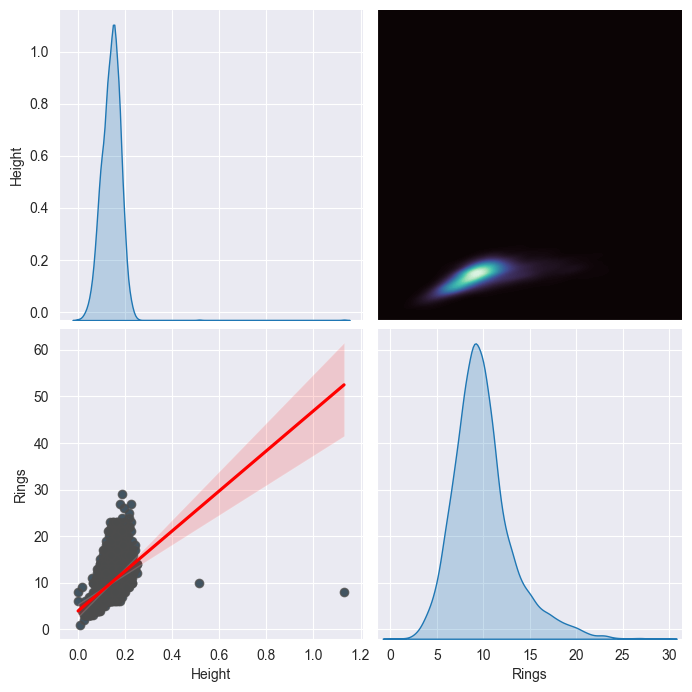

In [8]:
df_selecionado = df_molusco[ ~df_molusco.index.isin(list(dict_outliers['Height'][0]))].copy()

g = sns.pairplot(df_molusco, diag_kind='kde', height=3.5)
g.map_upper(sns.kdeplot,  fill=True, thresh=0, levels=100, cmap="mako")
g.map_lower(sns.regplot, color=".3", line_kws=dict(color="r"));

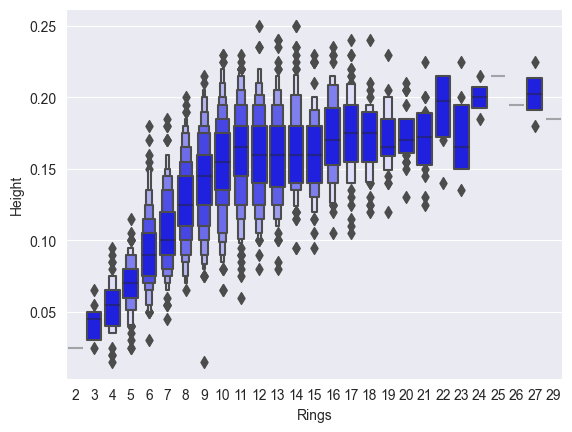

In [9]:
sns.boxenplot(x="Rings", y="Height",
              color="b",
              scale="linear",
            data=df_selecionado);

## 8.c, 8.d, 8.e)

In [10]:
dict_refactor = {'Height' : 'x', 'Rings' : 'y'}
LR = LinearReg(df_molusco.rename(columns=dict_refactor))
LR_out = LinearReg(df_selecionado.rename(columns=dict_refactor))

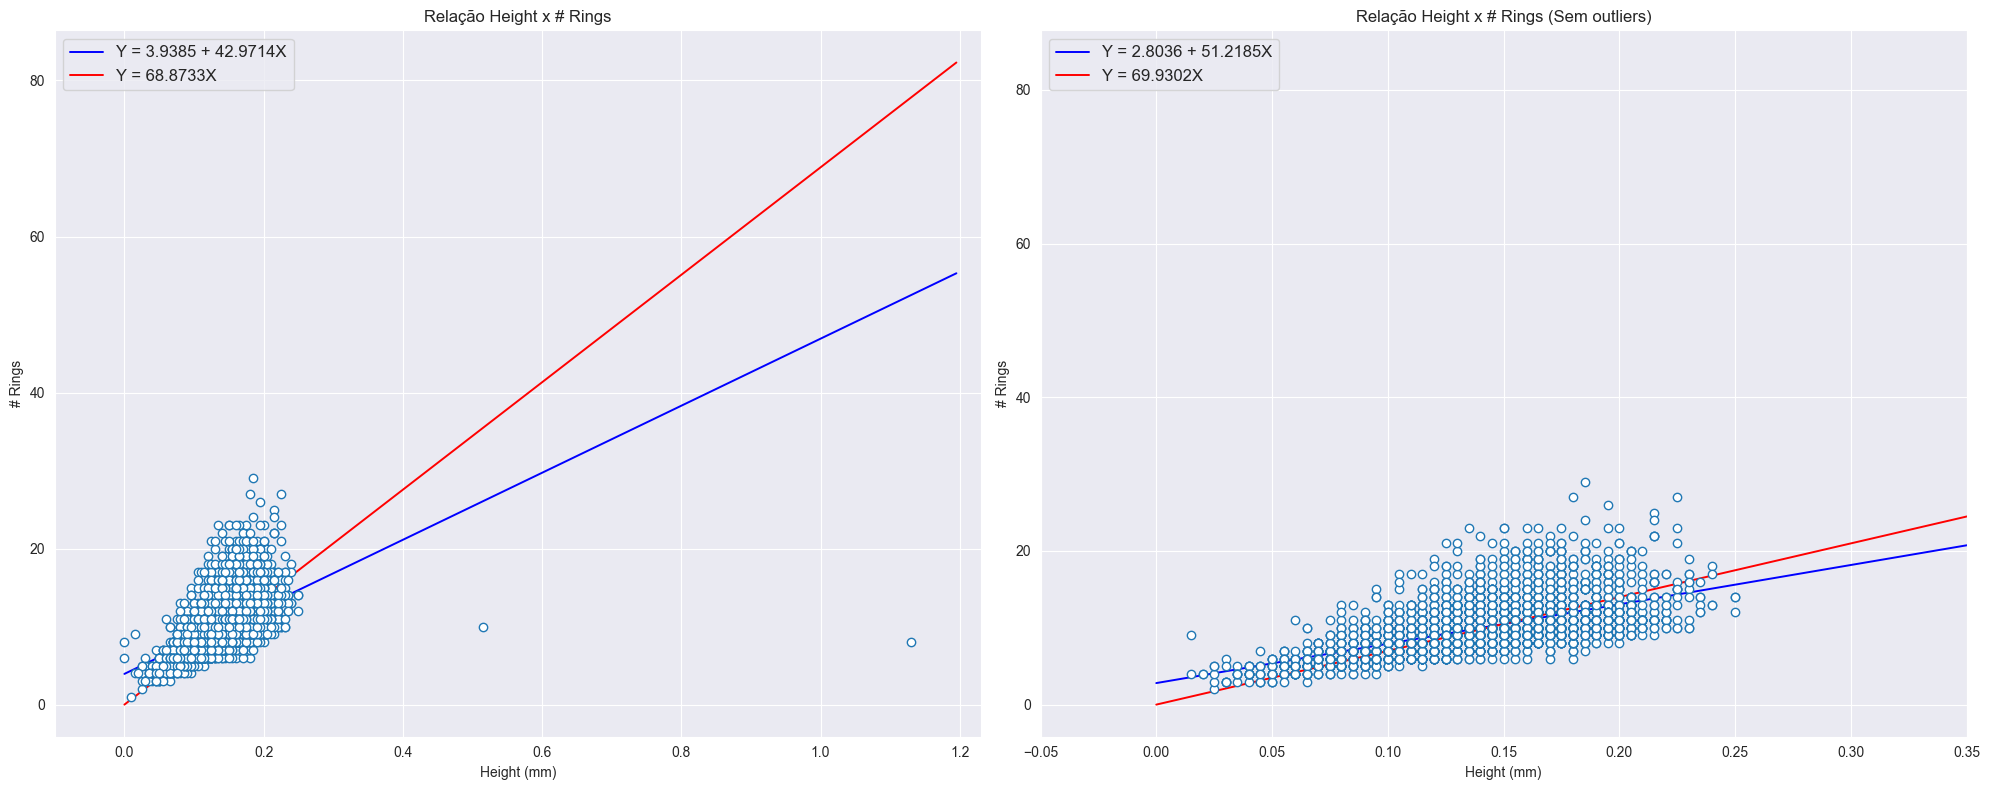

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8)) 

ax = axs[0]
bhat_1 = LR.model.params.x
bhat_0 = LR.model.params.intercept
b_hat = LR.model_origin.params.x

x_plot = np.linspace(0, df_molusco['Height'].iloc[-1]+1, 100)
y_hat = bhat_0 + x_plot*bhat_1
y_hat_origin = x_plot*b_hat

ax.plot(x_plot,y_hat,'-',color='blue',linewidth=1.4,label=f'Y = {bhat_0:.4f} + {bhat_1:.4f}X')
ax.plot(x_plot,y_hat_origin,'-',color='red',linewidth=1.4,label=f'Y = {b_hat:.4f}X')
ax.plot(df_molusco['Height'],df_molusco['Rings'], 'o',markerfacecolor='white')

ax.set_xlabel('Height (mm)')
ax.set_ylabel('# Rings')
ax.set_title('Relação Height x # Rings')
ax.legend(loc='upper left',fontsize=12)

ax.set_xlim([-0.1,df_molusco['Height'].max()+0.1])

ax = axs[1]
bhat_1 = LR_out.model.params.x
bhat_0 = LR_out.model.params.intercept
b_hat = LR_out.model_origin.params.x

x_plot = np.linspace(0, df_selecionado['Height'].iloc[-1]+1, 100)
y_hat = bhat_0 + x_plot*bhat_1
y_hat_origin = x_plot*b_hat

ax.plot(x_plot,y_hat,'-',color='blue',linewidth=1.4,label=f'Y = {bhat_0:.4f} + {bhat_1:.4f}X')
ax.plot(x_plot,y_hat_origin,'-',color='red',linewidth=1.4,label=f'Y = {b_hat:.4f}X')
ax.plot(df_selecionado['Height'],df_selecionado['Rings'], 'o',markerfacecolor='white')

ax.set_xlabel('Height (mm)')
ax.set_ylabel('# Rings')
ax.set_title('Relação Height x # Rings (Sem outliers)')
ax.legend(loc='upper left',fontsize=12)

ax.set_xlim([-0.05,df_selecionado['Height'].max()+0.1])

plt.tight_layout()    
plt.show()

Acima são representadas duas situações, sendo a da esquerda representando os dados completos e a da direita os dados sem outliers da variável Height. Para cada um dos casos, representa-se a regressão linear com intercepto (em azul) e sem intercepto (em vermelho), com as respectivas equações descritas na legenda. Fica evidente o efeito dos outliers (5 dados no total), com  o coeficiente $R^2$ aumentando de 0.31 para 0.37 no caso com intercepto e de 0.92 para 0.94 no caso sem intercepto, conforme os dados compilados abaixo.

## 8.f e 8.g)

A seguir são apresentados os intervalos de 95% confiança para os parâmetros Beta 0 e Beta 1, e a título de comparação compila-se também os dados para os casos sem intercepto e sem outliers, bem como expõe-se os valores de r2, t e erro padrão em cada caso.

In [12]:
print("Modelo com Outliers")
display(LR.df_resumo)
icb1, icb0 = LR.stats_simple_model(alpha=0.05)
icb = LR.stats_origin_model(alpha=0.05)
print(f"IC Beta 0 (95%) = [{icb0[0]:.4f}, {icb0[1]:.4f}]")
print(f"IC Beta 1 (95%) = [{icb1[0]:.4f}, {icb1[1]:.4f}]")
print(f"\nModelo sem intercepto:\nIC Beta 1 (95%) = [{icb[0]:.4f}, {icb[1]:.4f}]")

Modelo com Outliers


,Beta 1,se beta 1,t_beta 1,beta 0,se beta 0,t_beta 0,r2
modelo simples,42.971441,0.990409,43.387589,3.938464,0.144253,27.30248,0.310770
modelo origem,68.873328,0.308696,223.110818,0.000000,NaN,NaN,0.922601


IC Beta 0 (95%) = [3.6557, 4.2213]
IC Beta 1 (95%) = [41.0297, 44.9132]

Modelo sem intercepto:
IC Beta 1 (95%) = [68.2681, 69.4785]


In [13]:
print("Modelo sem Outliers")
display(LR_out.df_resumo)
icb1, icb0 = LR_out.stats_simple_model(alpha=0.05)
icb = LR_out.stats_origin_model(alpha=0.05)
print(f"IC Beta 0 (95%) = [{icb0[0]:.4f}, {icb0[1]:.4f}]")
print(f"IC Beta 1 (95%) = [{icb1[0]:.4f}, {icb1[1]:.4f}]")
print(f"\nModelo sem intercepto:\nIC Beta 1 (95%) = [{icb[0]:.4f}, {icb[1]:.4f}]")

Modelo sem Outliers


,Beta 1,se beta 1,t_beta 1,beta 0,se beta 0,t_beta 0,r2
modelo simples,51.218501,1.032322,49.614873,2.803613,0.149133,18.799454,0.371196
modelo origem,69.930178,0.285204,245.193273,0.000000,NaN,NaN,0.935123


IC Beta 0 (95%) = [2.5112, 3.0960]
IC Beta 1 (95%) = [49.1946, 53.2424]

Modelo sem intercepto:
IC Beta 1 (95%) = [69.3710, 70.4893]


É evidente, a partir dos dados apresentados acima, que existe relação estatística significante entre a altura e o número de anéis, com p-valores próximos a zero (a menor estatística t* é 18.80). Portanto, é possível afirmar que o uso de um modelo de Regressão linear para estimar a idade (através de sua relação direta com o número de anéis) utilizando-se da altura da conchas é válido e estatísticamente significante. 

## 8.h e 8.i)

In [14]:
print(r'Para X_h = 0.128, com significância de 5%, tem-se o seguinte intervalo de estimação:')
LR.ic_compute(x_h=0.128, alpha=0.05, estimation=True)

Para X_h = 0.128, com significância de 5%, tem-se o seguinte intervalo de estimação:
IC resp. media	[9.3546, 9.5230]


In [15]:
print(r'Para X_h = 0.132, com significância de 1%, tem-se o seguinte intervalo de predição:')
LR.ic_compute(x_h=0.132, n_pred=1, alpha=0.01, estimation=False)

Para X_h = 0.132, com significância de 1%, tem-se o seguinte intervalo de predição:
IC predicao		[2.7111, 16.5103]


# 8.j)

A partir dos resultados apresentados acima, é possível concluir que existe uma relação estatísticamente significativa entre a altura das conchas e o númeor de anéis, sendo esse parâmetro útil para se estimar a idade do animal.

No presente estudo compara-se o efeito dos outliers no desempenho do modelo, sendo que a retirada dos mesmos (somente considerando os outliers da variável Height) mostrou impactos positivos, principalmente por serem somente 5 observações retiradas. 

A consideração de um modelo sem intercepto resultou em um coeficiente $r^2$ elevado, na ordem de 0.90, quando comparado com o caso com intercepto, que resultou na ordem de 0.30. Porém, mais estudos são necessários para concluir se o modelo sem intercepto seria o mais adequado para esse caso.

Por fim, conclui-se que o modelo mais adequado aos dados seria o modelo simples, com intercepto e sem os 5 outliers da variável Height, resultando no seguinte modelo:

$$\hat{Y} = 2.8036 + 51.2185X$$